In [1]:
import numpy as np
import pandas as pd
idx = pd.IndexSlice
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from itertools import product

from scipy.stats import linregress

import sys
sys.path.append('../../funcs')
from taus import decorrelation_temporal_model, fit_coh_decay_model

In [12]:
dss = {fp.stem: xr.open_dataset(fp) for fp in sorted(list(Path('/Users/rdcrlzh1/Documents/uavsar-coherence/uavsar').glob('*.nc')))}

home_dir = Path('/Users/rdcrlzh1/Documents/uavsar-coherence')
fig_dir = home_dir.joinpath('figures', 'lidar')
home_dir.joinpath('figures', 'lidar', 'examples').mkdir()

In [19]:
pd.to_datetime(t).date()

datetime.date(2021, 3, 19)

fraser_full
lowman_full
rockmt_full
stlake_full


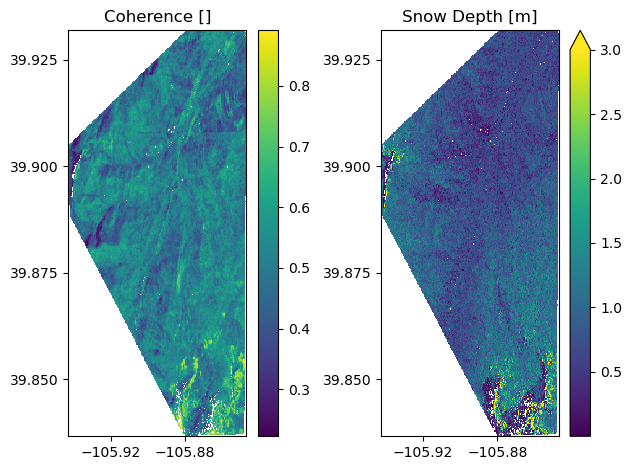

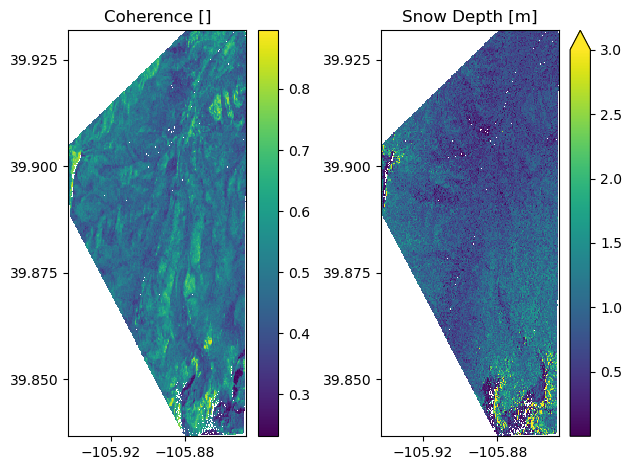

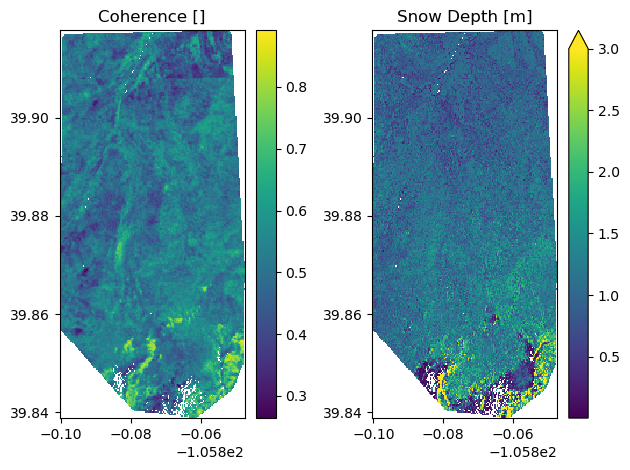

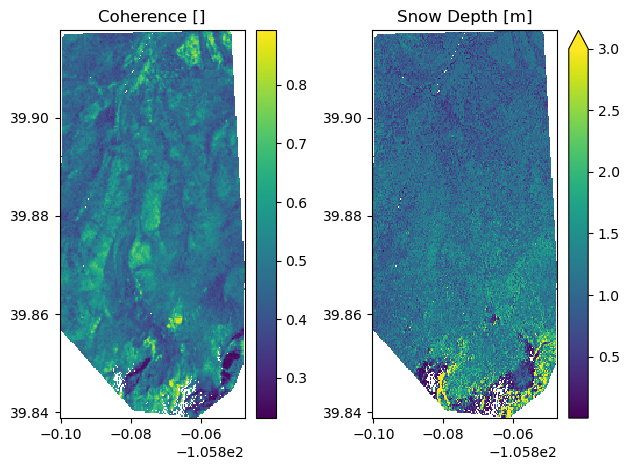

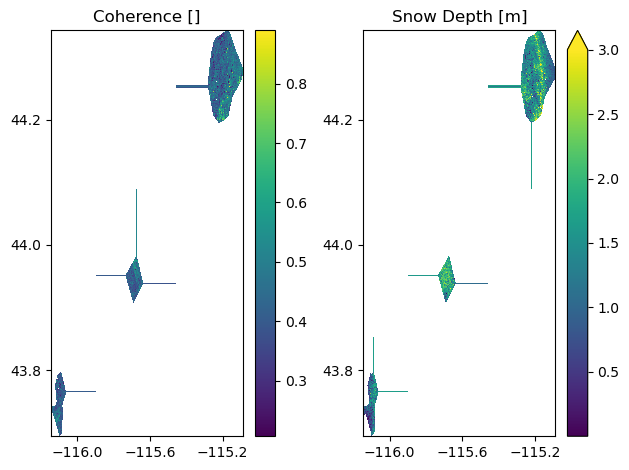

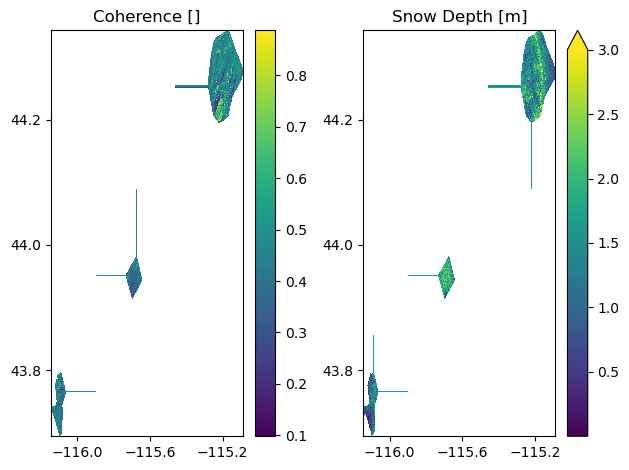

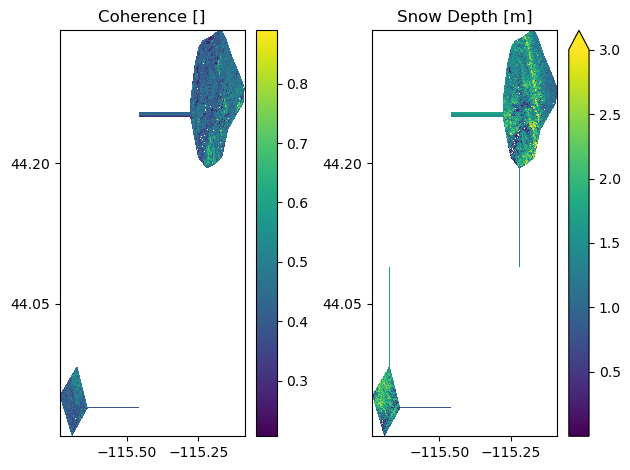

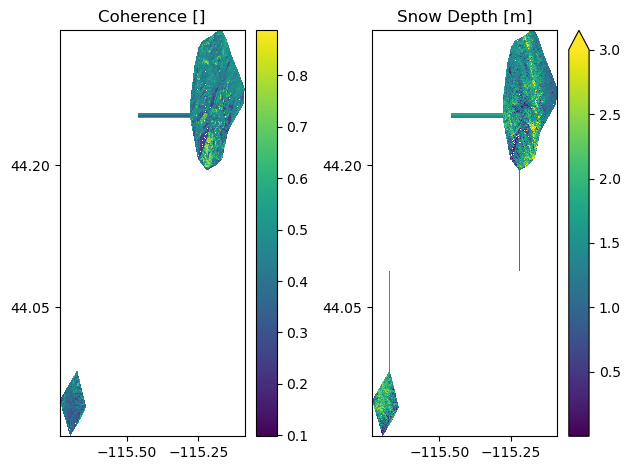

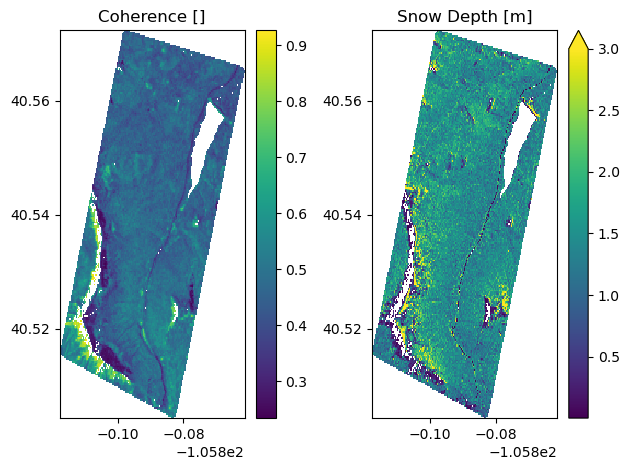

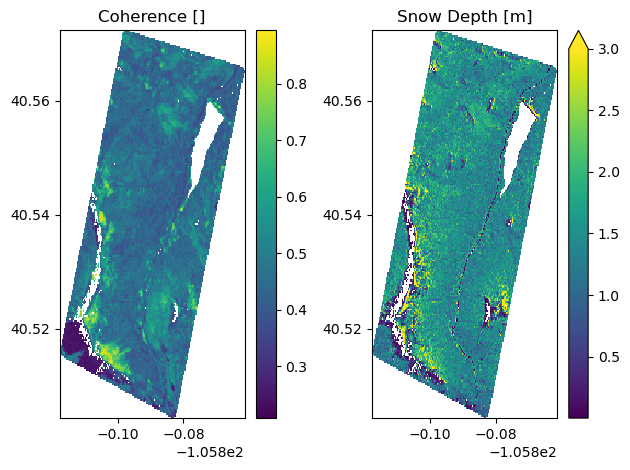

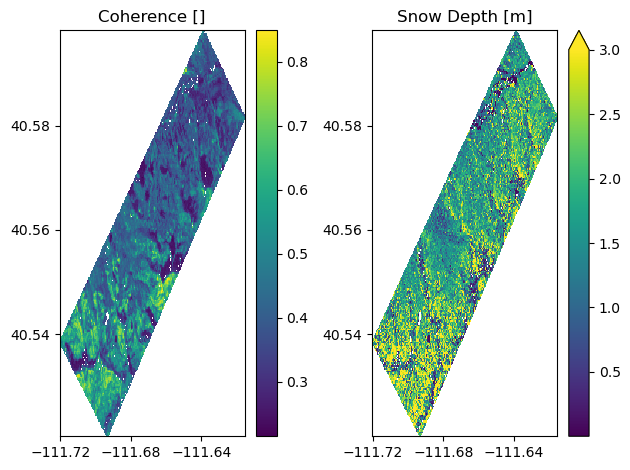

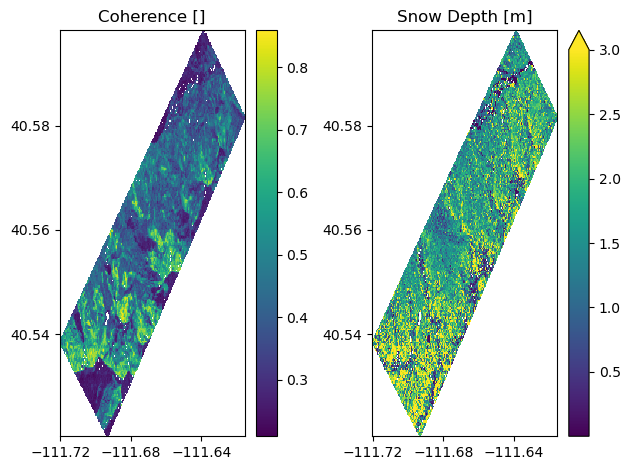

In [21]:
cohs = []
sds = []
for stem, ds_full in dss.items():
    if 'sd' not in ds_full.data_vars: continue
    print(stem)
    # if stem != 'fraser_full': continue
    for t, heading in product(ds_full.time.values, ds_full.heading.values):
        
        fig, axes = plt.subplots(1, 2) # , width_ratios=[1,1,3]
        ds = ds_full.sel(time = t).sel(heading = heading)
        cor = ds['cor'].sel(pol = 'HH').mean('time2').mean('time1')
        cor = cor.where(~ds['sd'].isnull())
        cor = cor.dropna('x', how = 'all').dropna('y', how = 'all')
        cor.plot(ax = axes[0], cbar_kwargs = {'label': ''})
        sd = ds['sd'].where(~cor.isnull()).dropna('x', how = 'all').dropna('y', how = 'all')
        sd.plot(ax = axes[1], vmax = 3, cbar_kwargs = {'label': ''})
        
        for ax in axes: 
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.xaxis.set_major_locator(plt.MaxNLocator(3))
            ax.yaxis.set_major_locator(plt.MaxNLocator(4))
            ax.ticklabel_format(axis='both', style='plain')

        axes[0].set_title('Coherence []')
        axes[1].set_title('Snow Depth [m]')
        plt.tight_layout()
        plt.savefig(fig_dir.joinpath('examples', f'sd-cor-{stem}_{pd.to_datetime(t).date()}_{heading}.png'))

        cor = cor.where(ds['inc'] < np.deg2rad(60))
        sd = sd.where(ds['inc'] < np.deg2rad(60))
        cohs.extend(cor.values.ravel())
        sds.extend(sd.values.ravel())

Slope: 0.021520942103190062. p: 0.0


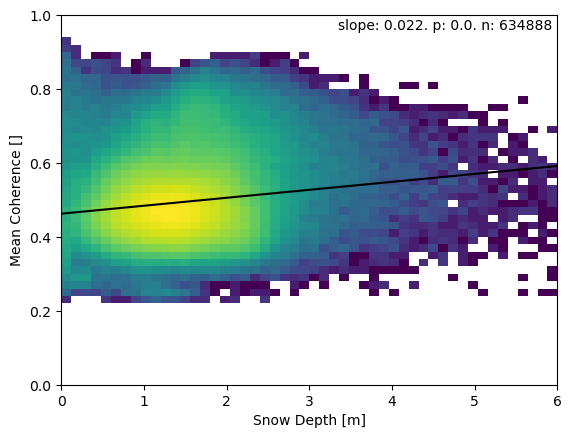

In [22]:
sds, cohs = np.array(sds), np.array(cohs)
ix = (~np.isnan(sds)) & (~np.isnan(cohs))
sds, cohs = sds[ix], cohs[ix]
plt.hist2d(sds, cohs, bins = 50, range = [[0, 6], [0, 1]], norm = mpl.colors.LogNorm())
ax = plt.gca()
x = sds
y = cohs
lm = linregress(x = x, y = y)
xs = np.linspace(np.min(x), np.max(x), 100)
ys = lm.slope * xs + lm.intercept
ax.plot(xs, ys, color = 'black')
print(f'Slope: {lm.slope}. p: {lm.pvalue}')
ax.text(0.99, 0.99, f'slope: {lm.slope:.3f}. p: {lm.pvalue}. n: {len(x)}', ha = 'right', va = 'top', transform=ax.transAxes)
ax.set_ylabel('Mean Coherence []')
ax.set_xlabel('Snow Depth [m]')
plt.savefig(fig_dir.joinpath('combo_lidar_sd.png'))